# Feature engineering and building a model for topic name prediction
## sample?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn

In [34]:
dt = pd.read_table("spark_data_merged.txt", error_bad_lines=False,encoding='utf-8-sig')
X = dt["Title"]
y = dt["Subreddit"]
dt.head(5)

b'Skipping line 4424: expected 2 fields, saw 3\nSkipping line 4459: expected 2 fields, saw 3\nSkipping line 4705: expected 2 fields, saw 3\nSkipping line 4904: expected 2 fields, saw 3\nSkipping line 5103: expected 2 fields, saw 3\nSkipping line 5309: expected 2 fields, saw 3\nSkipping line 5483: expected 2 fields, saw 3\nSkipping line 5658: expected 2 fields, saw 3\nSkipping line 5732: expected 2 fields, saw 3\nSkipping line 5943: expected 2 fields, saw 3\nSkipping line 12813: expected 2 fields, saw 3\n'


,Subreddit,Title
0,askreddit,What is the strangest thing to happen to you?
1,askreddit,What did your pet do that made them stand out ...
2,askreddit,What word or phrase do you say when you are an...
3,askreddit,at what point in a relationship do you start f...
4,askreddit,If you could create an STD what would it do?


As can be seen, the dataset is imbalanced. Askreddit, funny, pics and are traditionnally big subreddits in term of post count and subcribers. The_donald at the time the data set was collected is also quite active. 

In [30]:
dt["Subreddit"].value_counts()

askreddit      6533
the_donald     4429
funny          1561
pics           1223
gaming          970
worldnews       781
programming     366
Name: Subreddit, dtype: int64

In [32]:
# split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dt['Title'],
dt['Subreddit'], test_size=0.3, random_state=42)

In [37]:
## Feature engineering
# Tokenizing               
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer = 'word', ngram_range =(1,2))
X_train_counts = count_vect.fit_transform(X_train) 
# keep stopwords, all letters normalized

# from counts to frequency
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer=TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf=tf_transformer.transform(X_train_counts)
X_train_tf.shape

tfidf_transformer = TfidfTransformer() 
X_train_tfidf= tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape 

In [5]:
# Train with SVM using weight to deal with class imbalance
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()), # 'vect' here is just arbitrary name
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-4,
                                           max_iter=5, random_state=42, 
                                           class_weight = "balanced")),]) # weight inverserly proportional to class frequencies 

text_clf_svm = text_clf.fit(X_train, y_train)

In [7]:
%matplotlib inline

### Some performance metrics

             precision    recall  f1-score   support

  askreddit       0.92      0.96      0.94      1968
      funny       0.55      0.50      0.52       478
     gaming       0.71      0.68      0.70       284
       pics       0.57      0.63      0.60       380
programming       0.89      0.87      0.88       117
 the_donald       0.84      0.79      0.82      1302
  worldnews       0.67      0.73      0.70       230

avg / total       0.81      0.81      0.81      4759



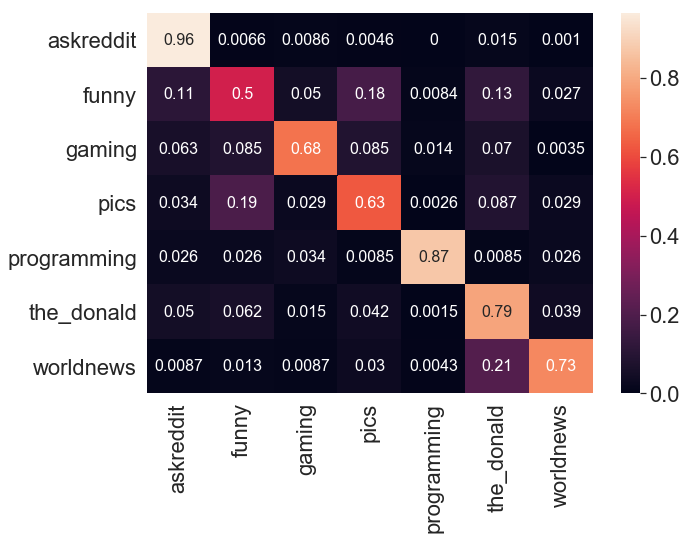

In [8]:
# Overall accuracy
predicted = text_clf_svm.predict(X_test)
np.mean(predicted == y_test) 

# per class accuracy
from sklearn import metrics
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=3)
print(metrics.classification_report(y_test, predicted)) 

# confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, predicted)

# normalized confusion matrix
cnf_matrix_normalized = cnf_matrix.astype('float') /cnf_matrix.sum(axis=1)[:, np.newaxis] 
categories = ['askreddit', 'funny', 'gaming', 'pics', 'programming', 'the_donald', 'worldnews']
df_cm = pd.DataFrame(cnf_matrix_normalized, index = [i for i in categories], 
                     columns = [i for i in categories])
fig=plt.figure(figsize = (10,7))
sn.set(font_scale=2)

# plot of normalized confusion matrix
sn.heatmap(df_cm, annot=True, annot_kws={"size":16}) 

### Perform a grid search 
A grid search is performed to conclude indeed using bigram, no stop words, and tfidf with hyperparameter \alpha of 0.0001 is the best approach

In [9]:
# perfrom GridSearch
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__stop_words': ("english", None),                      
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3, 1e-4),
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train[:2000], y_train[:2000])

gs_clf.best_score_
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name])) 

clf__alpha: 0.0001
tfidf__use_idf: True
vect__ngram_range: (1, 2)
vect__stop_words: None
